In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import argparse
import tensorflow as tf
from keras.utils import generic_utils as keras_generic_utils
from dataset import ds_x_decoded_y_original
from dataset import image_processing as ip
from test_tube import Experiment, HyperOptArgumentParser
from CAEWrapper import CAEWrapper
import json
import numpy as np
import h5py

Using TensorFlow backend.


In [ ]:
####################
## Make fake data ##
####################  
data_type_vec = ['training','validation','testing']

## Make fake data directories 
if not os.path.exists('FakeData'):
    os.makedirs('FakeData')
    for i_data_type in range(len(data_type_vec)):
        os.makedirs('FakeData/'+data_type_vec[i_data_type])
        os.makedirs('FakeData/'+data_type_vec[i_data_type]+'/images')
        os.makedirs('FakeData/'+data_type_vec[i_data_type]+'/ld-images')
        os.makedirs('FakeData/' + data_type_vec[i_data_type] + '/cae-images')
        
if not os.path.exists('FakeData/saved-models/'):
    os.makedirs('FakeData/saved-models/')

## Generate fake images and activities

for data_type in data_type_vec:
    
    image_dir = 'FakeData/'+data_type+'/images/'
    decodedimage_dir = 'FakeData/'+ data_type +'/ld-images/'
    
    #simulation string identifies what model was used to generate the activities/ld images (i.e. spatialSim, randSim, realData, etc.)
    sim_string = 'randSim'
    for i_block in range(3): # just create 3 blocks of each data type
        
        # images
        save_path = image_dir+str(i_block)+ '.h5'
        print(save_path)
        if not os.path.exists(save_path):
            Xorig = np.random.randint(0,255,(10000,256,256))
            h5_file = h5py.File(save_path,'w')
            h5_file.create_dataset('data',data=Xorig)
            h5_file.close()
        
        # decoded images- size 128x128 because we crop the middle 128x128 section to generate simulations and train models
        save_path = decodedimage_dir+str(i_block)+ '_' + sim_string + '.h5'
        print(save_path)
        if not os.path.exists(save_path):
            Xdec = np.random.randint(0,255,(10000,128,128))
            h5_file = h5py.File(save_path,'w')
            h5_file.create_dataset('data',data=Xdec)
            h5_file.close()
    

Setup CAE arguments for training- normally these would be passed into a command-line call to CAEWrapper.py but we place all arguments in the "default" here. We do not recommended running the entire CAE training through jupyter notebook. Shell scripts should be setup to call the CAEWrapper directly with the appropriate arguments. This is just to make sure that everything is running correctly. 

In [ ]:
# -----------------------------------------
# MAIN ENTRY POINT
# -----------------------------------------
parser = HyperOptArgumentParser(strategy='grid_search')

# hyperparams
parser.add_opt_argument_list('--drop_rate', default=0.25, type=float, options=[0.25, 0.5, 0.75], tunnable=False)
parser.add_opt_argument_list('--optimizer', default='adam', options=['adam', 'sgd', 'rmsprop'], tunnable=False)
parser.add_opt_argument_list('--lr', default=0.0004, type=float, options=[0.00005, 0.0001, 0.0002, 0.0004, 0.0008, 0.001, 0.002, 0.004], tunnable=True)

parser.add_argument('--loss', default='mse')
parser.add_argument('--max_to_keep', default=3, type=int)
parser.add_argument('--image_w', default=128, type=int)
parser.add_argument('--nb_img_channels', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--nb_epochs', default=40, type=int)
parser.add_argument('--eval_tng_err_every_n_batches', default=10, type=int)
parser.add_argument('--eval_val_err_every_n_batches', default=3100, type=int)
parser.add_argument('--nb_imgs_per_epoch', default=30000, type=int)
parser.add_argument('--nb_eval_imgs_to_save', default=3, type=int)
parser.add_argument('--debug', default=False, type=bool)
parser.add_argument('--gpu_mem_fraction', default=1.0, type=float)
parser.add_argument('--nb_val_batches', default=500, type=int, help='nb of batches from val dataset to compute val loss')
parser.add_argument('--early_stop_threshold', default=0.999, type=float)
parser.add_argument('--no_improvement_nb_epochs_to_stop', default=6, type=float)
parser.add_argument('--enable_early_stop', default=True, type=bool)
parser.add_argument('--normalize_scale', default=True, type=bool)

# tt params
parser.add_argument('-en', '--exp_name', default='test_fake_data')
parser.add_argument('--tt_save_dir', default='cae_fake_data_train')
parser.add_argument('-td', '--tt_description', default='cae mse lr=0.004 experiment')

parser.add_argument('--gpus_viz', default='0')

parser.add_argument('--model_save_dir', default='./FakeData/saved-models/')
parser.add_argument('--train_decoded_dir_path', default='./FakeData/training/ld-images/')
parser.add_argument('--train_original_dir_path', default='./FakeData/training/images')
parser.add_argument('--val_decoded_dir_path', default='./FakeData/validation/ld-images/')
parser.add_argument('--val_original_dir_path', default='./FakeData/validation/images/')
parser.add_argument('--decoded_suffix', default = 'randSim')
parser.add_argument('--image_norm_mean', default=0.4496052750126008, type=float)
parser.add_json_config_argument('-c', '--config', type=str)

hyperparams = parser.parse_args([])



In [ ]:
#Create model and train

caemodel = CAEWrapper(hyperparams)
caemodel.train_main()


Now that we have confirmed that everything is working in terms of data loading and training, we will show an example with the real data from our paper loading the CAE model and evaluating it on the linear decoded images to generate final decoded images, displaying those examples here. 

In [7]:
#Test images are located in data/imnet/images
#Test ld images are located in data/imnet/ld-images
#Corresponding cae outputs are located in data/imnet/cae-images
#Model directory: data/saved-models/CAE_imnet

testimg_dir = './data/imnet/images/'
testld_dir = './data/imnet/ld-images/'
testcae_dir = './data/imnet/cae-images/'
saved_model = './data/saved-models/CAE_imnet/model'


#Again set arguments for argparser here but this should normally be done in a shell script
parser = HyperOptArgumentParser()
parser.add_argument('--image_w', default=128, type=int)
parser.add_argument('--nb_test_imgs', default=200, type=int)
parser.add_argument('--nb_img_channels', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--debug', default=False, type=bool)
parser.add_argument('--gpu_mem_fraction', default=1.0, type=float)

#We want to save the prediction bucket to the desired directory and make sure these images match the pre-placed cae images in testcae_dir
parser.add_argument('--save_test_prediction_bucket', default=True, type=bool)
parser.add_argument('--test_prediction_save_path', default=testcae_dir, type=str)

# tt params
parser.add_argument('-en', '--exp_name', default='caetestbucket0')
parser.add_argument('--original_exp', default='')
parser.add_argument('--original_exp_version', default=0, type=int)
parser.add_argument('--tt_save_dir', default='cae_imnet_model_test')
parser.add_argument('-td', '--tt_description', default='')

parser.add_argument('--image_norm_mean', default=0.4496052750126008, type=float)
parser.add_argument('--normalize_scale', default=True, type=bool)  # controls whether you normalize by 255 and subtract image mean
parser.add_argument('--gpus_viz', default='0')

parser.add_argument('--predict_opt_name', default='predict_opt')
parser.add_argument('--input_tensor_name', default='input_x:0')

parser.add_argument('--model_ckpt_path', default=saved_model)
parser.add_argument('--test_decoded_dir_path', default=testld_dir)
parser.add_argument('--test_original_dir_path', default=testimg_dir)
parser.add_argument('--decoded_suffix', default = 'spatialSim')

parser.add_json_config_argument('-c', '--config', type=str)

hyperparams = parser.parse_args([])



In [8]:
#Run ca test_main
caemodel = CAEWrapper(hyperparams)
caemodel.test_main()


---------------------------------------------------------------------------------------------------- 
TNG PARAMS:
 ----------------------------------------------------------------------------------------------------
model_ckpt_path: ./data/saved-models/CAE_imnet/model
batch_size: 100
input_tensor_name: input_x:0
tt_save_dir: cae_imnet_model_test
original_exp_version: 0
trials: <bound method HyperOptArgumentParser.opt_trials of HyperOptArgumentParser(prog='__main__.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)>
nb_img_channels: 1
exp_name: caetestbucket0
nb_test_imgs: 200
test_prediction_save_path: ./data/imnet/cae-images/
predict_opt_name: predict_opt
test_original_dir_path: ./data/imnet/images/
normalize_scale: True
test_decoded_dir_path: ./data/imnet/ld-images/
debug: False
gpus_viz: 0
image_norm_mean: 0.4496052750126008
config: None
optimize_parallel: <bound method HyperOptArgumentParser.optimize_paralle

In [9]:
#cae decoded output from running our model testing
output_caedecoded = hyperparams.test_prediction_save_path + hyperparams.exp_name + '.h5'

#cae decoded output from our paper that we posted
output_caedecoded_paper = hyperparams.test_prediction_save_path + '0_spatialSim.h5'

#orig images 
output_orig = './data/imnet/images/0.h5'

#ld_images
output_ld = './data/imnet/ld-images/0_spatialSim.h5'


orig_bucket = np.float32(h5py.File(output_orig, 'r')['data'])
ld_bucket = h5py.File(output_ld, 'r')['data']
cae_test_bucket = h5py.File(output_caedecoded, 'r')['y_hat']
cae_paper_bucket = h5py.File(output_caedecoded_paper, 'r')['data']


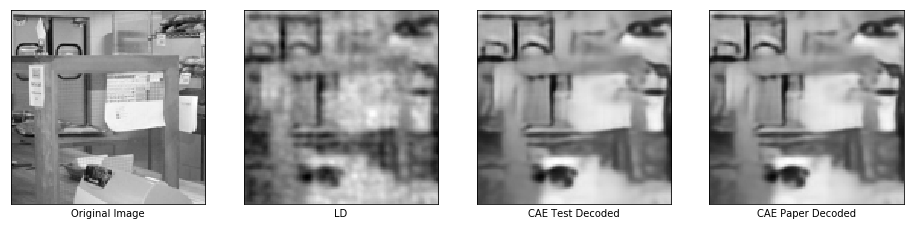

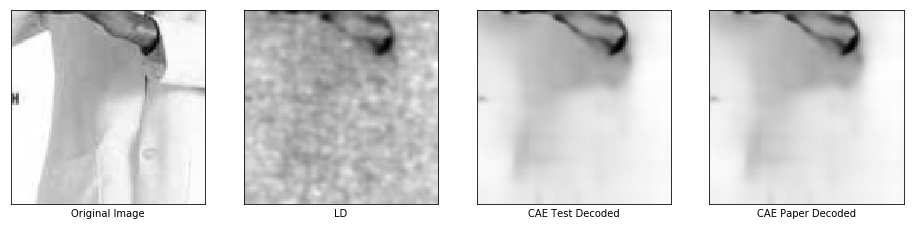

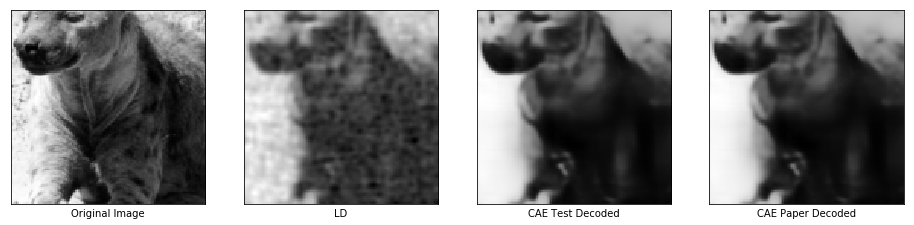

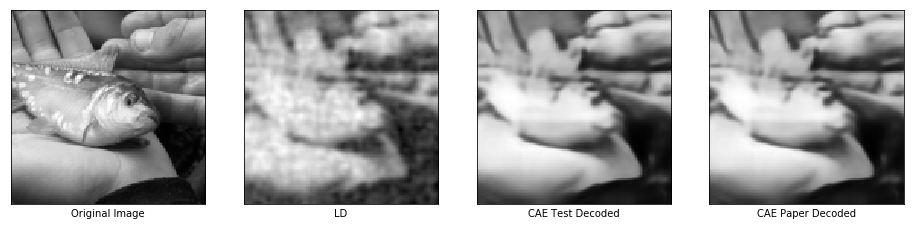

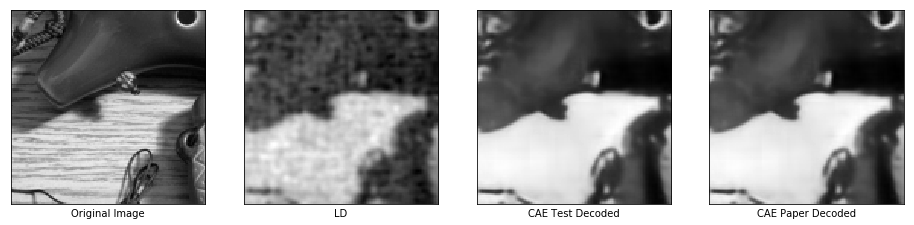

In [11]:
#Plot images for examples
import matplotlib.pyplot as plt
imsize = (128,128)
for i in range(5):
    fig, axs = plt.subplots(1, 4, figsize = (16,4))
    axs[0].matshow(orig_bucket[i,64:192, 64:192], cmap=plt.get_cmap('gray'))
    axs[1].matshow(np.reshape(ld_bucket[i,:], imsize), cmap=plt.get_cmap('gray'))
    axs[2].matshow(np.reshape(cae_test_bucket[i,:], imsize), cmap=plt.get_cmap('gray'))
    axs[3].matshow(np.reshape(cae_paper_bucket[i,:], imsize), cmap=plt.get_cmap('gray'))
    
    axs[0].set_xlabel('Original Image')
    axs[1].set_xlabel('LD')
    axs[2].set_xlabel('CAE Test Decoded')
    axs[3].set_xlabel('CAE Paper Decoded')
    
    for j in range(4):
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    
    plt.show()

    

The above predictions from loading the saved model and running the prediction script match the pre-placed output from the paper for the test bucket in ./data/imnet/cae-images. Using the test_tube package, the metrics and output jpeg images for the testing script are placed in ./cae_imnet_model_test/. You can also run the same above steps for the celeba dataset by changing the paths to the corresponding data in ./data/celeba/. This is done below and we again confirm that the predictions from loading the test model match the paper decoded images. 

In [12]:
testimg_dir = './data/celeba/images/'
testld_dir = './data/celeba/ld-images/'
testcae_dir = './data/celeba/cae-images/'
saved_model = './data/saved-models/CAE_celeba/model'


#Again set arguments for argparser here but this should normally be done in a shell script
parser = HyperOptArgumentParser()
parser.add_argument('--image_w', default=128, type=int)
parser.add_argument('--nb_test_imgs', default=200, type=int)
parser.add_argument('--nb_img_channels', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--debug', default=False, type=bool)
parser.add_argument('--gpu_mem_fraction', default=1.0, type=float)

#We want to save the prediction bucket to the desired directory and make sure these images match the pre-placed cae images in testcae_dir
parser.add_argument('--save_test_prediction_bucket', default=True, type=bool)
parser.add_argument('--test_prediction_save_path', default=testcae_dir, type=str)

# tt params
parser.add_argument('-en', '--exp_name', default='caetestbucket0')
parser.add_argument('--original_exp', default='')
parser.add_argument('--original_exp_version', default=0, type=int)
parser.add_argument('--tt_save_dir', default='cae_celeba_model_test')
parser.add_argument('-td', '--tt_description', default='')

parser.add_argument('--image_norm_mean', default=0.4496052750126008, type=float)
parser.add_argument('--normalize_scale', default=True, type=bool)  # controls whether you normalize by 255 and subtract image mean
parser.add_argument('--gpus_viz', default='0')

parser.add_argument('--predict_opt_name', default='predict_opt')
parser.add_argument('--input_tensor_name', default='input_x:0')

parser.add_argument('--model_ckpt_path', default=saved_model)
parser.add_argument('--test_decoded_dir_path', default=testld_dir)
parser.add_argument('--test_original_dir_path', default=testimg_dir)
parser.add_argument('--decoded_suffix', default = 'spatialSim')

parser.add_json_config_argument('-c', '--config', type=str)

hyperparams = parser.parse_args([])

In [13]:
#Run ca test_main
caemodel = CAEWrapper(hyperparams)
caemodel.test_main()

---------------------------------------------------------------------------------------------------- 
TNG PARAMS:
 ----------------------------------------------------------------------------------------------------
model_ckpt_path: ./data/saved-models/CAE_celeba/model
batch_size: 100
input_tensor_name: input_x:0
tt_save_dir: cae_celeba_model_test
original_exp_version: 0
trials: <bound method HyperOptArgumentParser.opt_trials of HyperOptArgumentParser(prog='__main__.py', usage=None, description=None, formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)>
nb_img_channels: 1
exp_name: caetestbucket0
nb_test_imgs: 200
test_prediction_save_path: ./data/celeba/cae-images/
predict_opt_name: predict_opt
test_original_dir_path: ./data/celeba/images/
normalize_scale: True
test_decoded_dir_path: ./data/celeba/ld-images/
debug: False
gpus_viz: 0
image_norm_mean: 0.4496052750126008
config: None
optimize_parallel: <bound method HyperOptArgumentParser.optimize_pa

In [14]:
#cae decoded output from running our model testing
output_caedecoded = hyperparams.test_prediction_save_path + hyperparams.exp_name + '.h5'

#cae decoded output from our paper that we posted
output_caedecoded_paper = hyperparams.test_prediction_save_path + '0_spatialSim.h5'

#orig images 
output_orig = './data/celeba/images/0.h5'

#ld_images
output_ld = './data/celeba/ld-images/0_spatialSim.h5'


orig_bucket = np.float32(h5py.File(output_orig, 'r')['data'])
ld_bucket = h5py.File(output_ld, 'r')['data']
cae_test_bucket = h5py.File(output_caedecoded, 'r')['y_hat']
cae_paper_bucket = h5py.File(output_caedecoded_paper, 'r')['data']

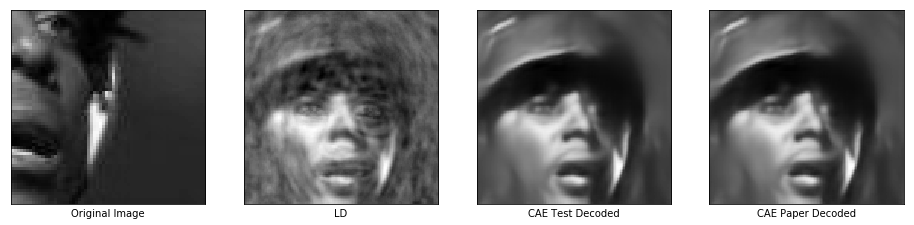

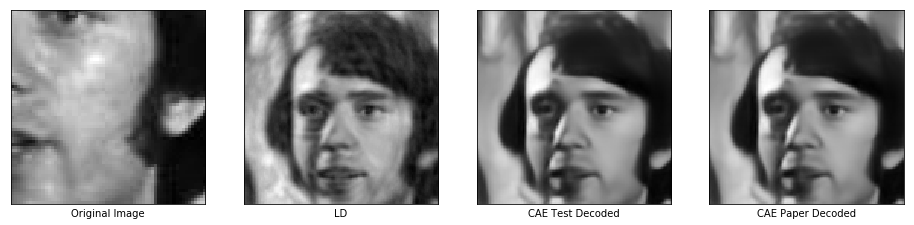

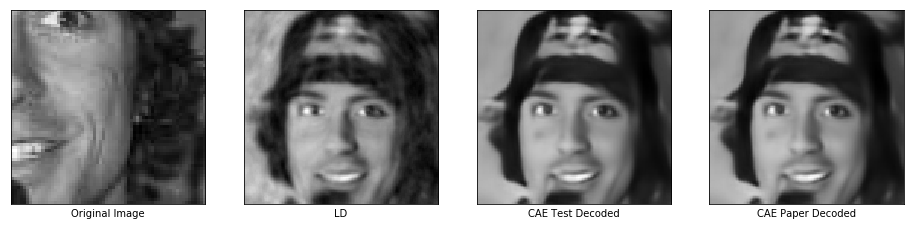

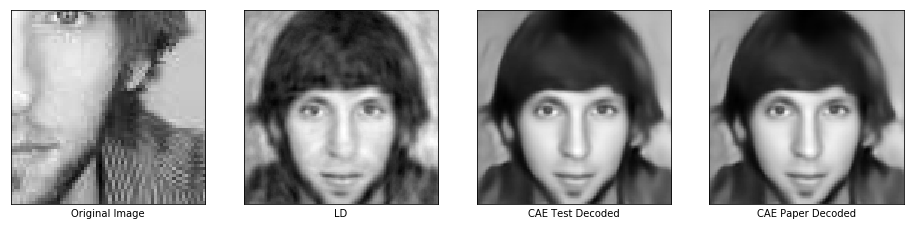

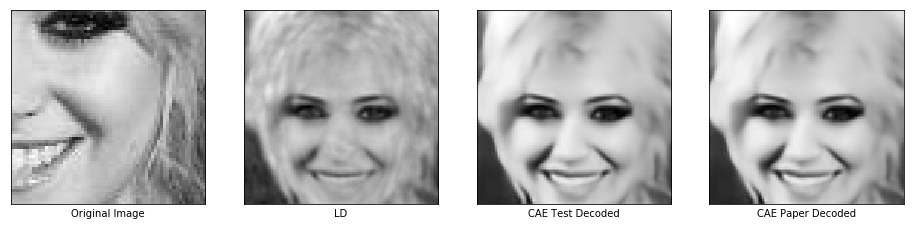

In [15]:
for i in range(5):
    fig, axs = plt.subplots(1, 4, figsize = (16,4))
    axs[0].matshow(orig_bucket[i,64:192, 64:192], cmap=plt.get_cmap('gray'))
    axs[1].matshow(np.reshape(ld_bucket[i,:], imsize), cmap=plt.get_cmap('gray'))
    axs[2].matshow(np.reshape(cae_test_bucket[i,:], imsize), cmap=plt.get_cmap('gray'))
    axs[3].matshow(np.reshape(cae_paper_bucket[i,:], imsize), cmap=plt.get_cmap('gray'))
    
    axs[0].set_xlabel('Original Image')
    axs[1].set_xlabel('LD')
    axs[2].set_xlabel('CAE Test Decoded')
    axs[3].set_xlabel('CAE Paper Decoded')
    
    for j in range(4):
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    
    plt.show()